In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle
from scipy.stats import pearsonr

! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
analysis_set = pd.read_csv("csvs/AnalysisDataset.csv")

In [41]:
reviews = analysis_set["cleanedText"]
reviews = reviews.apply(lambda x: re.sub(r"\s+", " ", str(x)).strip() if isinstance(x, (str, float, int)) else x)

In [42]:
unseen_reviews = []
for review in reviews:
    unseen_reviews.append(review)

In [43]:
unseen_reviews

['lightweight soft much small liking would preferred two together make one loc reason repurchasing',
 'really like ear swab first come large handy box easy store last long time second organic good environment third strong fall apart easily highly recommend used year',
 'honest rarely used overnight cream typically skin care routine morning night wash apply hyalauronic serum kind moistutrizer saw iryasa cream wanted try easy apply immediately feel moisture starting work apply minute actually go sleep allow time absorbed putting face pillow thicker type cream need time skin morning feel better ever soft supple definitely feel difference using week highly recommend cream woman men',
 'ok good original wet brush knock',
 'purchased see could set mom hair fine thin short hair think could fun fluffy set mom super old school hoping little foam styling product',
 'great multi pack band great price wash well laundry lose elasticity',
 'easy use',
 'good way use face oil normally skip facial oil

In [44]:
with open('embedded.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [45]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [46]:
from keras.models import load_model

model_path = 'lstm_model.keras'
pretrained_lstm_model = load_model(model_path)
pretrained_lstm_model.summary()
preds = pd.Series()
preds = pretrained_lstm_model.predict(unseen_padded)
# unseen_sentiments

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     6,029,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,381,833 (24.34 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 6,029,700 (23.00 MB)

 Optimizer params: 234,756 (917.02 KB)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step


In [47]:
preds = (preds > 0.5).astype(int).flatten()

In [48]:
analysis_set["predictedSentiment"] = preds
analysis_set.head(1)

,Unnamed: 0,category,brand,item,rating,cleanedText,text_length,timestamp,numRating,average_rating,total_votes,popularity_score,predictedSentiment
0,0,All Beauty,niseyo,Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...,3.0,lightweight soft much small liking would prefe...,32,2021-10-15 05:20:59.292,62.0,4.3,0,38.49,1


In [49]:
analysis_set.to_csv("csvs/Predictions.csv")

In [50]:
df = pd.DataFrame()
df = pd.read_csv("csvs/Predictions.csv")

In [51]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month']= df['timestamp'].dt.month

# Grouped months by their mean popularity scores

In [52]:
popularity_by_month = df.groupby(['category', 'month'])['popularity_score'].mean().div(1000).round(2).reset_index()

In [53]:
def get_top_categories_by_month(month_num):
    # Filter for the specific month
    month_data = popularity_by_month[popularity_by_month['month'] == month_num]
    
    # Sort by popularity_score in descending order and take top 5
    top_categories = month_data.sort_values('popularity_score', ascending=False).head(3)
    
    return top_categories

In [54]:
top_categories_by_month = {}
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

In [55]:
for i in range(1, 13):
    top_categories = get_top_categories_by_month(i)
    top_categories_by_month[month_names[i-1]] = top_categories

In [56]:
result_df = pd.DataFrame()

for month_name, top_data in top_categories_by_month.items():
    if not top_data.empty:
        # Add month name as a column
        top_data_with_month = top_data.copy()
        top_data_with_month['month_name'] = month_name
        
        # Append to result DataFrame
        result_df = pd.concat([result_df, top_data_with_month])

In [57]:
final_result = result_df[['month', 'month_name', 'category', 'popularity_score']].sort_values(
    by=['month', 'popularity_score'], 
    ascending=[True, False]
)

In [58]:
final_result.drop(columns=["month"], inplace=True)
final_result

,month_name,category,popularity_score
187,January,Gift Cards,43.44
36,January,Amazon Devices,21.09
144,January,Camera & Photo,18.38
37,February,Amazon Devices,55.95
188,February,Gift Cards,40.36
133,February,Buy a Kindle,28.15
189,March,Gift Cards,30.31
332,March,Prime Video,8.44
74,March,Appstore for Android,7.90
190,April,Gift Cards,27.07


In [59]:
df = pd.read_csv("csvs/Predictions.csv")

In [60]:
df['timestamp']= pd.to_datetime(df['timestamp'])
df['month']= df['timestamp'].dt.month

In [61]:
group= df.groupby(['category', 'month']).agg(totalReviews=('predictedSentiment', 'count'), positive=('predictedSentiment', 'sum')).reset_index()

In [62]:
group['ratio']= group['positive'] / group['totalReviews']
group['ratio']= group['ratio'].round(2)
# group

In [63]:
groupMonth= group.pivot(index= 'category', columns= 'month', values= 'totalReviews').fillna(0)
groupRatio= group.pivot(index= 'category', columns= 'month', values= 'ratio').fillna(0)

In [64]:
months= range(1, 13) #1 -> 12
month_names= ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

#reindexs to make category not the index anymore
groupMonth= groupMonth.reindex(columns= months, fill_value= 0.0).astype(float)
groupRatio= groupRatio.reindex(columns= months, fill_value= 0).astype(float)

In [65]:
totalRatio= pd.concat([
    groupMonth.rename(columns= dict(zip(months, [f"{i}_Total"for i in month_names]))),
    groupRatio.rename(columns= dict(zip(months, [f"{i}_Ratio"for i in month_names])))
], axis= 1)

In [66]:
columnOrder= []
for i in month_names:
    columnOrder.extend([f"{i}_Total", f"{i}_Ratio"])

In [67]:
totalRatio= totalRatio[columnOrder].reset_index()

In [68]:
totalCols= [col for col in totalRatio.columns if '_Total' in col]
totalRatio[totalCols]= totalRatio[totalCols].astype(int)

In [69]:
totalRatio

month,category,January_Total,January_Ratio,February_Total,February_Ratio,March_Total,March_Ratio,April_Total,April_Ratio,May_Total,...,August_Total,August_Ratio,September_Total,September_Ratio,October_Total,October_Ratio,November_Total,November_Ratio,December_Total,December_Ratio
0,AMAZON FASHION,95,0.86,62,0.89,86,0.90,89,0.91,75,...,69,0.93,67,0.91,81,0.91,57,0.89,74,0.88
1,All Beauty,130,0.90,105,0.86,127,0.92,110,0.80,120,...,129,0.84,89,0.82,92,0.86,100,0.88,123,0.81
2,All Electronics,45,0.82,31,0.87,18,0.72,16,0.81,16,...,13,0.85,23,0.96,21,0.86,19,1.00,34,0.91
3,Amazon Devices,4,1.00,1,1.00,0,0.00,3,1.00,1,...,3,1.00,1,1.00,0,0.00,2,1.00,4,1.00
4,Amazon Home,201,0.89,142,0.88,157,0.83,155,0.88,154,...,145,0.88,115,0.87,165,0.83,159,0.91,164,0.84
5,Apple Products,0,0.00,2,1.00,0,0.00,1,0.00,0,...,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00
6,Appliances,42,0.86,29,0.86,38,0.95,25,0.88,26,...,29,0.90,35,0.91,36,0.89,32,0.78,46,0.91
7,Appstore for Android,89,0.79,60,0.82,65,0.77,64,0.72,65,...,71,0.69,75,0.73,76,0.78,43,0.74,70,0.73
8,"Arts, Crafts & Sewing",10,0.90,18,0.94,10,1.00,13,0.85,15,...,18,0.83,18,0.94,10,0.90,16,0.88,9,0.67
9,Automotive,14,0.71,13,0.85,11,0.91,8,0.75,16,...,10,1.00,10,0.90,11,1.00,13,0.85,9,0.89


# Visualization for all categories and their popularity over the months

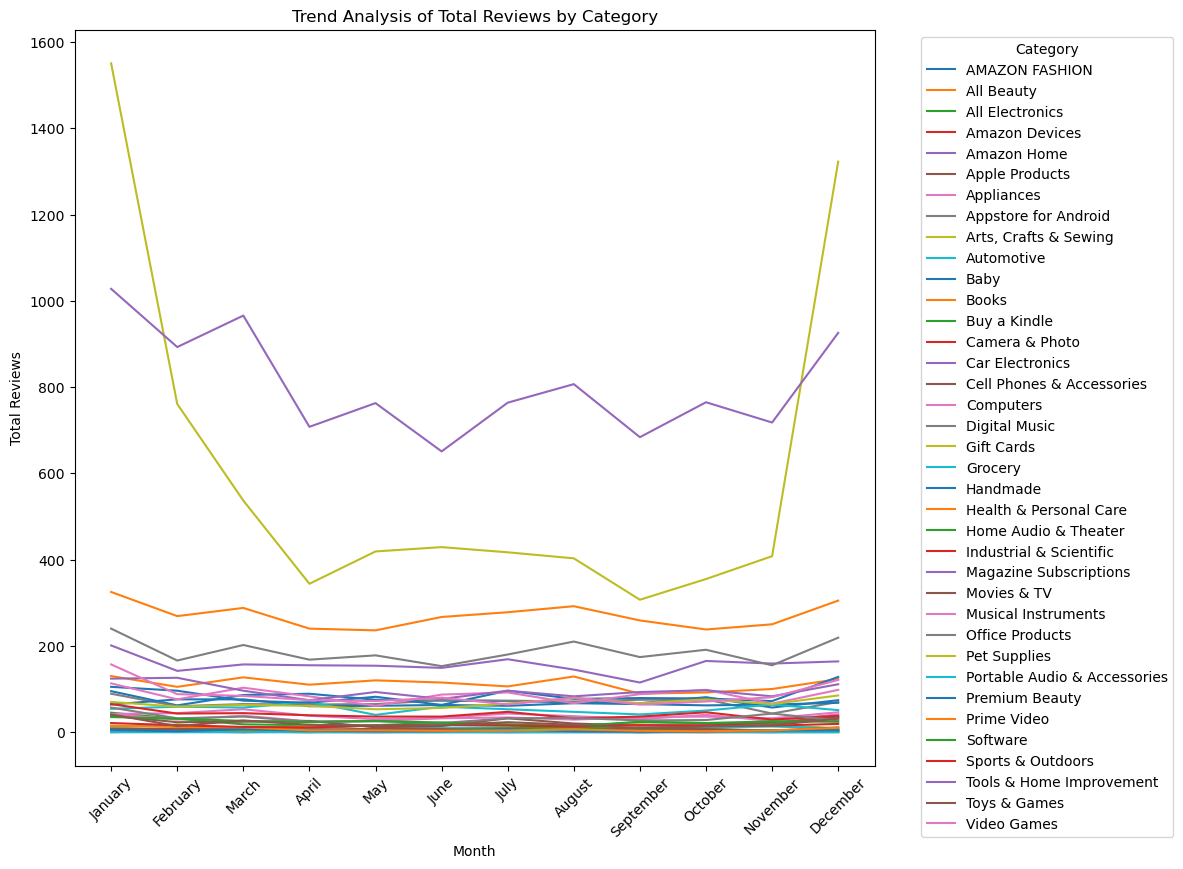

In [70]:
#get total columns
totalCols = [col for col in totalRatio.columns if '_Total' in col]

#melt the frame
melted= totalRatio.melt(id_vars='category', value_vars=totalCols, var_name='Month', value_name='TotalReviews')

melted['Month'] = melted['Month'].str.replace('_Total', '')
melted['Month'] = pd.Categorical(melted['Month'], categories=month_names, ordered=True)

#plot 
plt.figure(figsize=(12, 9))
for category in melted['category'].unique():
    category_data = melted[melted['category'] == category]
    plt.plot(category_data['Month'], category_data['TotalReviews'], label=category)

#supposed to get the max value but it dont work :\
# max_point = category_data.loc[category_data['TotalReviews'].idxmax()]
# plt.text(max_point['Month'], max_point['TotalReviews'], category, fontsize=9, ha='center', va='bottom')

plt.title('Trend Analysis of Total Reviews by Category')
plt.xlabel('Month')
plt.ylabel('Total Reviews')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization for single category popularity

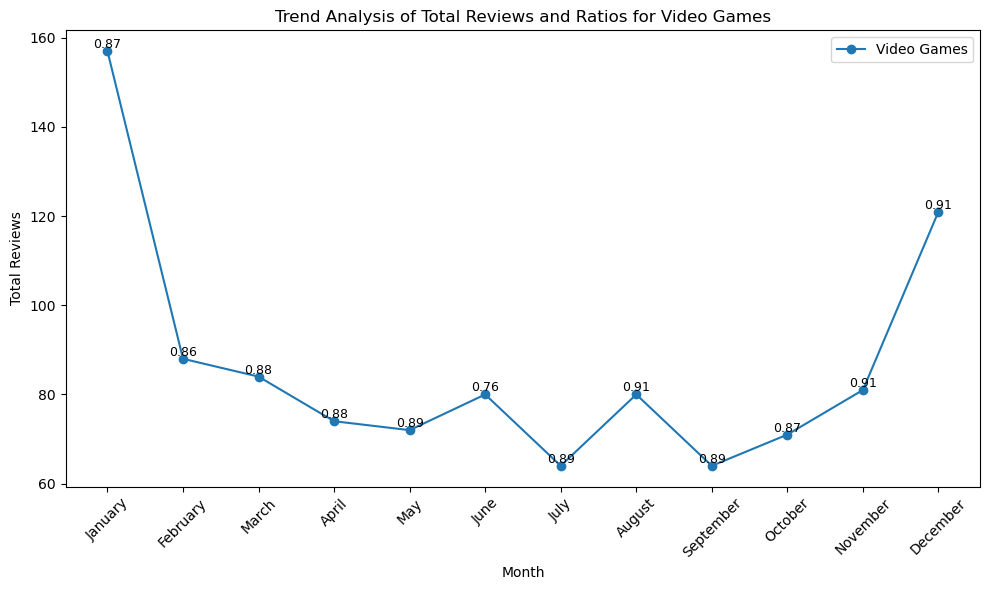

In [71]:
# #The category you want to plot
# selected= "Video Games"

# #melt frame
# category_data = melted[melted['category'] == selected]

# #Plot
# plt.figure(figsize=(10, 6))
# plt.plot(category_data['Month'], category_data['TotalReviews'], marker='o', label=selected)


# plt.title(f'Trend Analysis of Total Reviews for {selected}')
# plt.xlabel('Month')
# plt.ylabel('Total Reviews')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

#chosen category
selected = "Video Games"

#get the columns for each (WHY IS IT SO COMPLICTED TO GET THE DAMN RATIO TO SHOW)
total_review_cols = [col for col in totalRatio.columns if '_Total' in col]
ratio_cols = [col for col in totalRatio.columns if '_Ratio' in col]

# grab the categories from the categories frame
category_data = totalRatio[totalRatio['category'] == selected]

#melt frames to have each set of data
melted_reviews = category_data.melt(id_vars='category', value_vars=total_review_cols, var_name='Month', value_name='TotalReviews')
melted_ratios = category_data.melt(id_vars='category', value_vars=ratio_cols, var_name='Month', value_name='Ratio')

#fix column names
melted_reviews['Month'] = melted_reviews['Month'].str.replace('_Total', '')
melted_ratios['Month'] = melted_ratios['Month'].str.replace('_Ratio', '')

#merge em back in
melted_data = pd.merge(melted_reviews, melted_ratios, on=['category', 'Month'])

#plot
plt.figure(figsize=(10, 6))
plt.plot(melted_data['Month'], melted_data['TotalReviews'], marker='o', label=selected)

#finally put the damn ratios
for i, row in melted_data.iterrows():
    plt.text(row['Month'], row['TotalReviews'], f"{row['Ratio']:.2f}", fontsize=9, ha='center', va='bottom')

plt.title(f'Trend Analysis of Total Reviews and Ratios for {selected}')
plt.xlabel('Month')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
#dataframe for brand information
brandTotal= df.groupby(['category', 'brand', 'month']).agg(totalReviews=('predictedSentiment', 'count'), positive=('predictedSentiment', 'sum')).reset_index()

brandTotal['ratio']= (brandTotal['positive'] / brandTotal['totalReviews']).round(2)

#pivot for reviews and ratios
brandMonth= brandTotal.pivot(index= ['category', 'brand'], columns= 'month', values= 'totalReviews').fillna(0)
brandRatio= brandTotal.pivot(index= ['category', 'brand'], columns= 'month', values= 'ratio').fillna(0)

#concat frames
# brandFinal= pd.concat(
#     [brandMonth.add_suffix('_Total'), brandRatio.add_suffix('_Ratio')]
# , axis= 1).reset_index()
brandFinal= pd.concat([
    brandMonth.rename(columns= dict(zip(months, [f"{i}_Total"for i in month_names]))),
    brandRatio.rename(columns= dict(zip(months, [f"{i}_Ratio"for i in month_names])))
], axis= 1)

# columnOrder= []
# for i in month_names:
#     columnOrder.extend([f"{i}_Total", f"{i}_Ratio"])

brandFinal= brandFinal[columnOrder].reset_index()

totalCols= [col for col in brandFinal.columns if '_Total' in col]
brandFinal[totalCols]= brandFinal[totalCols].astype(int)

# #sort by category
# brandTotal= brandTotal.sort_values(by=['category'])

brandFinal.head(1)

month,category,brand,January_Total,January_Ratio,February_Total,February_Ratio,March_Total,March_Ratio,April_Total,April_Ratio,...,August_Total,August_Ratio,September_Total,September_Ratio,October_Total,October_Ratio,November_Total,November_Ratio,December_Total,December_Ratio
0,AMAZON FASHION,acefeel,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


# Visualization for top 10 brands in a category and their popularity

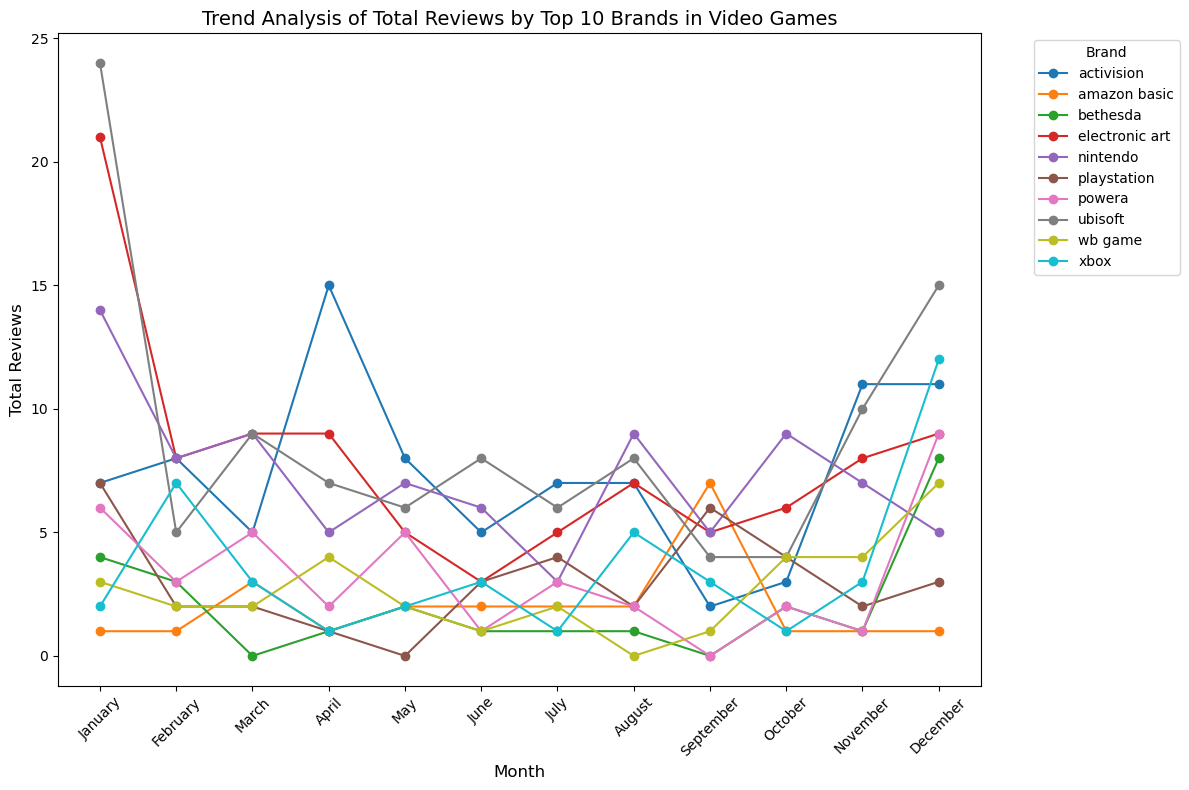

In [73]:
selected= "Video Games"

#Filter for brand
category_brands = brandTotal[brandTotal['category'] == selected]

#get total reviews for brands
brand_totals = category_brands.groupby('brand')['totalReviews'].sum().reset_index()

#Get the top 10
top_brands = brand_totals.nlargest(10, 'totalReviews')['brand']

#Filter the original frame to only include top 10 
top_brands_data = category_brands[category_brands['brand'].isin(top_brands)]

#repivot data
brand_monthly_reviews = top_brands_data.pivot(index='brand', columns='month', values='totalReviews').fillna(0)

#plot
plt.figure(figsize=(12, 8))
for brand in brand_monthly_reviews.index:
    plt.plot(brand_monthly_reviews.columns, brand_monthly_reviews.loc[brand], marker='o', label=brand)

plt.title(f'Trend Analysis of Total Reviews by Top 10 Brands in {selected}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization of Two Brands Side by Side

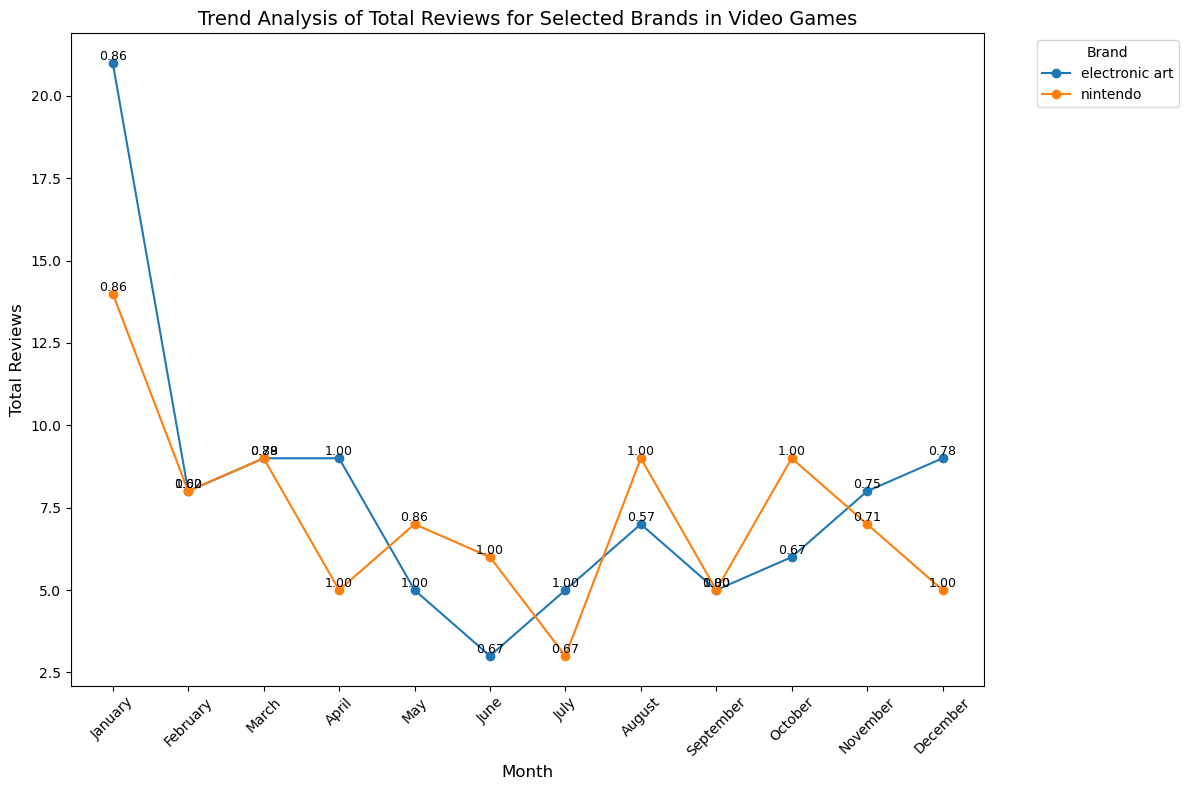

In [74]:
selected_category = "Video Games"  # Replace with the actual category name
selected_brands = ["nintendo", "electronic art"]  # Replace with the actual brand names

# Filter the DataFrame for the selected category and brands
category_brands = brandTotal[(brandTotal['category'] == selected_category) & 
                             (brandTotal['brand'].isin(selected_brands))]

# Pivot the data to have months as columns for totalReviews
brand_monthly_reviews = category_brands.pivot(index='brand', columns='month', values='totalReviews').fillna(0)
brand_monthly_ratios = category_brands.pivot(index='brand', columns='month', values='ratio').fillna(0)

# Plot the trend for the selected brands
plt.figure(figsize=(12, 8))
for brand in brand_monthly_reviews.index:
    plt.plot(brand_monthly_reviews.columns, brand_monthly_reviews.loc[brand], marker='o', label=brand)

    for month in brand_monthly_reviews.columns:
        total_reviews = brand_monthly_reviews.loc[brand, month]
        ratio = brand_monthly_ratios.loc[brand, month]
        plt.text(month, total_reviews, f"{ratio:.2f}", fontsize=9, ha='center', va='bottom')

# Add labels and title
plt.title(f'Trend Analysis of Total Reviews for Selected Brands in {selected_category}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [75]:
df

,Unnamed: 0.1,Unnamed: 0,category,brand,item,rating,cleanedText,text_length,timestamp,numRating,average_rating,total_votes,popularity_score,predictedSentiment,month
0,0,0,All Beauty,niseyo,Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...,3.0,lightweight soft much small liking would prefe...,32,2021-10-15 05:20:59.292,62.0,4.3,0,38.49,1,10
1,1,1,All Beauty,bali boo,Organic Bamboo Cotton Ear Swabs by Bali Boo - ...,5.0,really like ear swab first come large handy bo...,56,2020-08-03 16:49:11.088,49.0,4.2,0,30.66,1,8
2,2,2,All Beauty,iryasa,Iryasa Night Indulge Cream - Natural Face Crea...,5.0,honest rarely used overnight cream typically s...,126,2020-06-28 13:53:42.858,38.0,3.7,1,24.01,1,6
3,3,3,All Beauty,fine touch,Original Detangler Hair Brush,3.0,ok good original wet brush knock,14,2018-03-26 19:17:04.726,7.0,3.2,0,5.16,1,3
4,4,4,All Beauty,annie,1/8 inch Snap On Rollers 8 Pack (Pink),5.0,purchased see could set mom hair fine thin sho...,53,2020-08-08 15:44:00.832,23.0,4.3,0,15.09,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40182,40182,40182,NaN,gagowa,Black White Tapestry Wall Hanging for Bedroom ...,5.0,really big color bright bold,10,2022-06-30 16:10:55.178,5.0,4.7,0,4.41,1,6
40183,40183,40183,NaN,pepsi,"Diet Pepsi Cans, 12 FlOz, 12 Count",5.0,price,1,2020-10-30 15:19:00.702,2551.0,4.7,1,1532.11,1,10
40184,40184,40184,NaN,annie homegrown,"Annie's White Cheddar Macaroni & Cheese, Micro...",5.0,never white macaroni cheese something different,8,2020-08-02 20:45:28.194,1980.0,4.4,0,1189.32,0,8
40185,40185,40185,NaN,kar,Kar’s Nuts Peanut Butter ‘N Dark Chocolate Tra...,5.0,good addicting practically everyone office wan...,33,2015-07-02 21:09:16.000,4.0,4.7,0,3.81,1,7


# Correlation between review length and sentiment

Pearson correlation coefficient: 0.0355
P-value: 0.0000


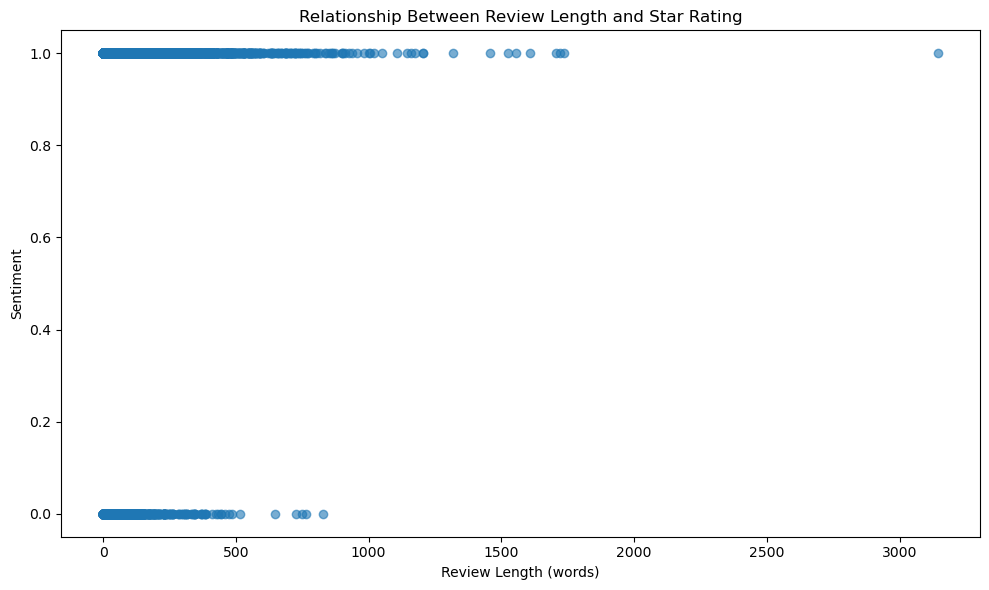

In [83]:
correlation, p_value = pearsonr(df['text_length'], df['predictedSentiment'])
print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")



plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['predictedSentiment'], alpha=0.6)
plt.title('Relationship Between Review Length and Star Rating')
plt.xlabel('Review Length (words)')
plt.ylabel('Sentiment')


# plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}\nP-value: {p_value:.4f}', 
#          transform=plt.gca().transAxes, fontsize=12, 
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()